# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AvgPool2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=42) 

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [5]:
len(labels['real_age'].unique())

97

Text(0.5, 0, 'Возраст, годы')

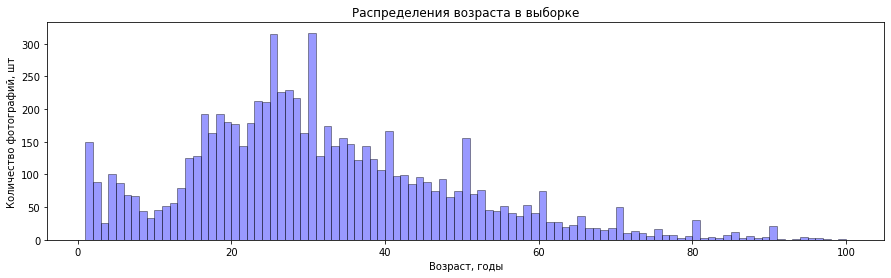

In [6]:
plt.figure(figsize=(15,4))
sns.distplot(labels['real_age'], hist=True, kde=False, 
             bins=np.linspace(1, 100, num = 100), color = 'blue',
             hist_kws={'edgecolor':'black'})
plt.title('Распределения возраста в выборке')
plt.ylabel('Количество фотографий, шт')
plt.xlabel('Возраст, годы')

In [7]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


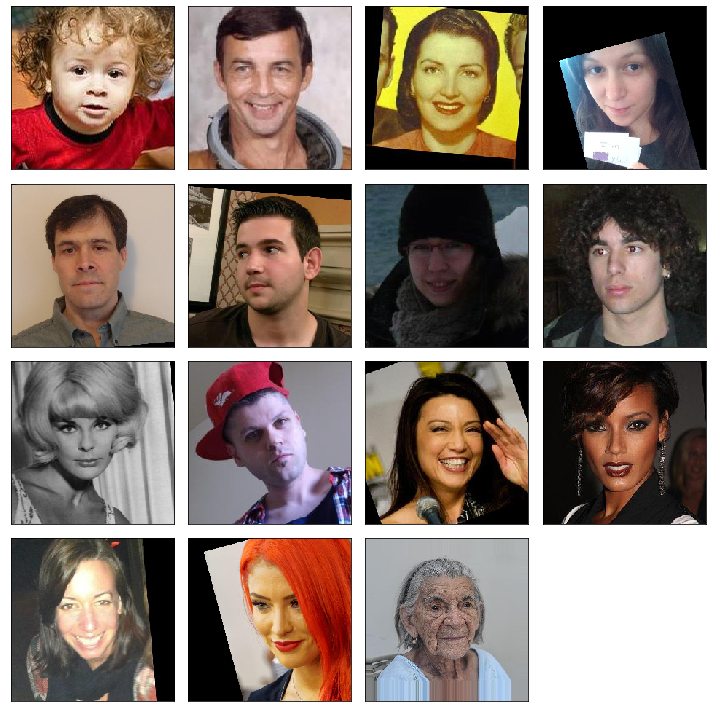

In [8]:
features, target = next(train_gen_flow)
 
fig = plt.figure(figsize=(10, 10))
for i in range(15):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод:

У нас для обучения 7591 фотография людей от 1 года до 100 лет, половина из них от 20 до 41 года, людей младше 15 лет мало, как и возрастных, что не должно помешать нашей цели. Странный всплеск людей возраста 1 год, если не получится достич необходимого уровня точности, от него можно попробовать избавиться. Все фото разного кочества, иногда с искажениями.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AvgPool2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1. / 255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1. / 255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None,epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

178/178 - 45s - loss: 205.0094 - mae: 10.6676 - val_loss: 372.5789 - val_mae: 14.3430
Epoch 2/10
178/178 - 37s - loss: 101.7033 - mae: 7.7214 - val_loss: 289.6851 - val_mae: 13.6130
Epoch 3/10
178/178 - 37s - loss: 65.8660 - mae: 6.1715 - val_loss: 422.7036 - val_mae: 15.4221
Epoch 4/10
178/178 - 37s - loss: 44.4113 - mae: 5.1318 - val_loss: 219.3526 - val_mae: 11.0429
Epoch 5/10
178/178 - 37s - loss: 31.2983 - mae: 4.2935 - val_loss: 123.0488 - val_mae: 8.6404
Epoch 6/10
178/178 - 37s - loss: 23.2354 - mae: 3.7210 - val_loss: 81.8618 - val_mae: 6.6786
Epoch 7/10
178/178 - 37s - loss: 19.0016 - mae: 3.3655 - val_loss: 92.5340 - val_mae: 7.3709
Epoch 8/10
178/178 - 37s - loss: 14.4503 - mae: 2.9302 - val_loss: 89.5989 - val_mae: 7.0142
Epoch 9/10
178/178 - 37s - loss: 11.9671 - mae: 2.6424 - val_loss: 86.3210 - val_mae: 7.0130
Epoch 10/10
178/178 - 37s - loss: 11.0158 - mae: 2.5464 - val_loss: 81.4269 - val_mae: 6.7132
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 81.4269 - mae: 6.7132
Test MAE: 6.7132

```

## Анализ обученной модели

Модель ошибается в среднем на 7 лет, что является достаточным для нас показателем, я сам часто не могу определить возраст точнее, учитывая, что люди старшего возраста могут выглядеть очень по разному, в зависимости от своего здоровья и ухоженности. Могу предположить, что также как и я, модель не сделает большую ошибку при определении возраста детей и подростков.

Мы дообучили готовую модель ResNet50 обученную на датасете Imagenet. Потребовалось 10 эпох.